In [1]:
import tensorflow as tf
import keras
import pandas
import konlpy
import gensim

print(pandas.__version__)
print(konlpy.__version__)
print(gensim.__version__)

1.3.3
0.5.2
4.1.2


In [2]:
import pandas as pd

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [3]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

In [4]:
print(word_to_index)

{'<PAD>': 0, '<BOS>': 1, '<UNK>': 2, '<UNUSED>': 3, '.': 4, '영화': 5, '다': 6, '고': 7, '하': 8, '을': 9, '보': 10, '..': 11, '게': 12, ',': 13, '!': 14, '지': 15, '있': 16, '없': 17, '?': 18, '좋': 19, '나': 20, '었': 21, '만': 22, '는데': 23, '너무': 24, '봤': 25, '적': 26, '안': 27, '정말': 28, '로': 29, '음': 30, '것': 31, '아': 32, '네요': 33, '재밌': 34, '어': 35, '같': 36, '점': 37, '지만': 38, '진짜': 39, '했': 40, '에서': 41, '기': 42, '네': 43, '않': 44, '거': 45, '았': 46, '수': 47, '되': 48, '면': 49, 'ㅋㅋ': 50, '말': 51, '연기': 52, '인': 53, '주': 54, '내': 55, '최고': 56, '~': 57, '평점': 58, '이런': 59, '던': 60, '어요': 61, '할': 62, '왜': 63, '겠': 64, '1': 65, '스토리': 66, '해': 67, '습니다': 68, 'ㅋㅋㅋ': 69, '...': 70, '드라마': 71, '생각': 72, '아니': 73, '더': 74, '그': 75, '싶': 76, '사람': 77, '듯': 78, '때': 79, '감동': 80, '함': 81, '배우': 82, '본': 83, '까지': 84, '뭐': 85, '알': 86, '만들': 87, '내용': 88, '볼': 89, '감독': 90, '보다': 91, '라': 92, '그냥': 93, '재미': 94, '시간': 95, '지루': 96, '중': 97, '재미있': 98, '년': 99, '10': 100, '였': 101, '잼': 102, '사랑': 103, '못': 1

In [56]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [62]:
len(index_to_word)

10000

In [58]:
print(index_to_word[5]) 

영화


In [5]:
print(X_train[0], X_train[1])

[32, 74, 919, 4, 4, 39, 228, 20, 33, 748] [1028, 4, 11, 519, 549, 687, 5, 120, 4, 70, 1639, 52, 925, 1006, 15, 44, 391]


In [6]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [7]:
total_data_text = list(X_train) + list(X_test)
# [[32, 74, 919, 4, 4, 39, 228, 20, 33, 748], ... ]
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print(f'전체 문장의 {(np.sum(num_tokens < max_tokens) / len(num_tokens))*100}%가 maxlen 설정값 이내에 포함됩니다. ')

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 93.42988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [8]:
print(word_to_index['<BOS>'])
print(word_to_index['<UNK>'])

1
2


In [9]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'pre'
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'pre'
                                                       maxlen=maxlen)

print(X_train.shape)

(146182, 41)


## 모델 설계
### 1-D CNN, LSTM, GRU
1. word_vector_dim 조절
2. layer 수 조절

In [10]:
print(len(word_to_index))

10000


### CNN

In [11]:
vocab_size = 10000
word_vector_dim = 16

cnn_base = keras.Sequential()
cnn_base.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
cnn_base.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
cnn_base.add(tf.keras.layers.MaxPooling1D(5))
cnn_base.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
cnn_base.add(tf.keras.layers.GlobalMaxPooling1D())
cnn_base.add(tf.keras.layers.Dense(8, activation='relu'))
cnn_base.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

cnn_base.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 8)                 136       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9

### LSTM

In [68]:
lstm_base = keras.Sequential()
lstm_base.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
lstm_base.add(tf.keras.layers.LSTM(8))
lstm_base.add(tf.keras.layers.Dense(8, activation='relu'))
lstm_base.add(tf.keras.layers.Dense(1, activation='sigmoid'))

lstm_base.summary() 

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 100)         1000000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 8)                 3488      
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 9         
Total params: 1,003,569
Trainable params: 1,003,569
Non-trainable params: 0
_________________________________________________________________


### GRU

In [13]:
gru_base = keras.Sequential()
gru_base.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
gru_base.add(tf.keras.layers.GRU(16))
gru_base.add(tf.keras.layers.Dense(8, activation='relu'))
gru_base.add(tf.keras.layers.Dense(1, activation='sigmoid'))

gru_base.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
gru (GRU)                    (None, 16)                1632      
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 161,777
Trainable params: 161,777
Non-trainable params: 0
_________________________________________________________________


In [14]:
len(X_train), len(X_test)

(146182, 49157)

## Validation set 구성

In [15]:
# validation set 50000건 분리
X_val = X_train[:50000]   
y_val = y_train[:50000]

# validation set을 제외한 나머지 96000여건
partial_X_train = X_train[50000:]  
partial_y_train = y_train[50000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(96182, 41)
(96182,)


## cnn_base 학습

In [16]:
cnn_base.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20

cnn_base_history = cnn_base.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
188/188 [==============================] - 70s 8ms/step - loss: 0.5319 - accuracy: 0.7278 - val_loss: 0.3650 - val_accuracy: 0.8401
Epoch 2/20
188/188 [==============================] - 1s 5ms/step - loss: 0.3394 - accuracy: 0.8552 - val_loss: 0.3473 - val_accuracy: 0.8478
Epoch 3/20
188/188 [==============================] - 1s 5ms/step - loss: 0.3029 - accuracy: 0.8743 - val_loss: 0.3434 - val_accuracy: 0.8499
Epoch 4/20
188/188 [==============================] - 1s 5ms/step - loss: 0.2778 - accuracy: 0.8854 - val_loss: 0.3468 - val_accuracy: 0.8499
Epoch 5/20
188/188 [==============================] - 1s 5ms/step - loss: 0.2533 - accuracy: 0.8984 - val_loss: 0.3573 - val_accuracy: 0.8492
Epoch 6/20
188/188 [==============================] - 1s 5ms/step - loss: 0.2258 - accuracy: 0.9127 - val_loss: 0.3696 - val_accuracy: 0.8473
Epoch 7/20
188/188 [==============================] - 1s 5ms/step - loss: 0.1954 - accuracy: 0.9278 - val_loss: 0.3915 - val_accuracy: 0.8441
Epoch

In [17]:
results = cnn_base.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.9765 - accuracy: 0.8125
[0.9765419960021973, 0.8125393986701965]


train accuracy는 매우 높은데, validation accuracy와 test accuracy가 비교적 낮음.

## lstm_base 학습

In [69]:
lstm_base.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

lstm_base_history = lstm_base.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
188/188 [==============================] - 3s 9ms/step - loss: 0.4722 - accuracy: 0.7952 - val_loss: 0.3688 - val_accuracy: 0.8426
Epoch 2/10
188/188 [==============================] - 1s 7ms/step - loss: 0.3367 - accuracy: 0.8610 - val_loss: 0.3545 - val_accuracy: 0.8471
Epoch 3/10
188/188 [==============================] - 1s 7ms/step - loss: 0.3072 - accuracy: 0.8750 - val_loss: 0.3524 - val_accuracy: 0.8503
Epoch 4/10
188/188 [==============================] - 1s 7ms/step - loss: 0.2862 - accuracy: 0.8843 - val_loss: 0.3529 - val_accuracy: 0.8494
Epoch 5/10
188/188 [==============================] - 1s 7ms/step - loss: 0.2689 - accuracy: 0.8917 - val_loss: 0.3577 - val_accuracy: 0.8504
Epoch 6/10
188/188 [==============================] - 1s 7ms/step - loss: 0.2519 - accuracy: 0.8996 - val_loss: 0.3694 - val_accuracy: 0.8466
Epoch 7/10
188/188 [==============================] - 1s 7ms/step - loss: 0.2347 - accuracy: 0.9070 - val_loss: 0.3821 - val_accuracy: 0.8486
Epoch 

In [70]:
results = lstm_base.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.4272 - accuracy: 0.8389
[0.42720115184783936, 0.8388632535934448]


cnn_base와 비교했을 때
train accuracy는 조금 더 낮지만, val accuracy & train accuracy 모두 cnn_base보다 더 높음
따라서 lstm_base > cnn_base

## gru_base 학습

In [20]:
gru_base.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

gru_base_history = gru_base.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
188/188 [==============================] - 3s 8ms/step - loss: 0.5061 - accuracy: 0.7581 - val_loss: 0.3653 - val_accuracy: 0.8423
Epoch 2/20
188/188 [==============================] - 1s 6ms/step - loss: 0.3440 - accuracy: 0.8535 - val_loss: 0.3538 - val_accuracy: 0.8469
Epoch 3/20
188/188 [==============================] - 1s 6ms/step - loss: 0.3204 - accuracy: 0.8688 - val_loss: 0.3540 - val_accuracy: 0.8481
Epoch 4/20
188/188 [==============================] - 1s 6ms/step - loss: 0.3090 - accuracy: 0.8751 - val_loss: 0.3584 - val_accuracy: 0.8461
Epoch 5/20
188/188 [==============================] - 1s 6ms/step - loss: 0.3003 - accuracy: 0.8789 - val_loss: 0.3585 - val_accuracy: 0.8471
Epoch 6/20
188/188 [==============================] - 1s 6ms/step - loss: 0.2926 - accuracy: 0.8833 - val_loss: 0.3633 - val_accuracy: 0.8456
Epoch 7/20
188/188 [==============================] - 1s 6ms/step - loss: 0.2863 - accuracy: 0.8865 - val_loss: 0.3644 - val_accuracy: 0.8471
Epoch 

In [21]:
results = gru_base.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.4483 - accuracy: 0.8376
[0.44834965467453003, 0.837561309337616]


val accuracy & test accuracy로 봤을 때 lstm_base와 거의 같은 점수.  
물론 layer 개수, layer에 들어간 unit 개수 등 조절 가능한 hyper parameter의 경우가 많기 때문에(search_space가 많아)  
cnn, lstm, gru 아키텍처 자체에 대한 비교라 할 수 없지만,
cnn_base < lstm_base ~= gru_base 라 할 수 있겠다.

## 모델 성능 시각화

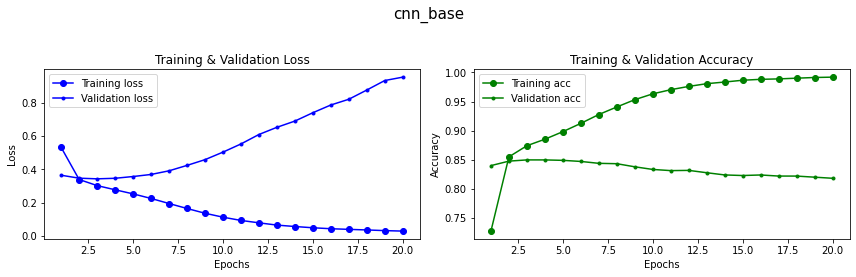

In [22]:
import matplotlib.pyplot as plt

cnn_base_history_dict = cnn_base_history.history

acc     = cnn_base_history_dict['accuracy']
val_acc = cnn_base_history_dict['val_accuracy']
loss    = cnn_base_history_dict['loss']
val_loss= cnn_base_history_dict['val_loss']
epochs  = range(1, len(acc) + 1)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# left subplot: Loss
ax1.plot(epochs, loss,    'bo-', label='Training loss')
ax1.plot(epochs, val_loss,'b.-', label='Validation loss')
ax1.set_title('Training & Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

# right subplot: Accuracy
ax2.plot(epochs, acc,     'go-', label='Training acc')
ax2.plot(epochs, val_acc, 'g.-', label='Validation acc')
ax2.set_title('Training & Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

fig.suptitle('cnn_base', fontsize=15)

fig.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

epoch 3부터 overfitting.

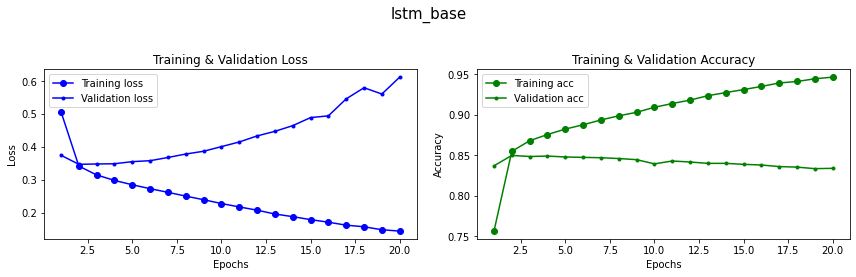

In [24]:
import matplotlib.pyplot as plt

lstm_base_history_dict = lstm_base_history.history

acc     = lstm_base_history_dict['accuracy']
val_acc = lstm_base_history_dict['val_accuracy']
loss    = lstm_base_history_dict['loss']
val_loss= lstm_base_history_dict['val_loss']
epochs  = range(1, len(acc) + 1)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# left subplot: Loss
ax1.plot(epochs, loss,    'bo-', label='Training loss')
ax1.plot(epochs, val_loss,'b.-', label='Validation loss')
ax1.set_title('Training & Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

# right subplot: Accuracy
ax2.plot(epochs, acc,     'go-', label='Training acc')
ax2.plot(epochs, val_acc, 'g.-', label='Validation acc')
ax2.set_title('Training & Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

fig.suptitle('lstm_base', fontsize=15)

fig.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

lstm_base도 epoch 3부터 overfitting이 시작된다.
epoch가 너무 많이 설정된 듯하다.

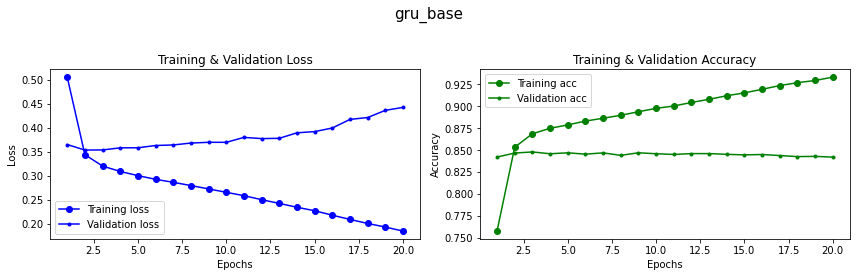

In [25]:
import matplotlib.pyplot as plt

gru_base_history_dict = gru_base_history.history

acc     = gru_base_history_dict['accuracy']
val_acc = gru_base_history_dict['val_accuracy']
loss    = gru_base_history_dict['loss']
val_loss= gru_base_history_dict['val_loss']
epochs  = range(1, len(acc) + 1)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# left subplot: Loss
ax1.plot(epochs, loss,    'bo-', label='Training loss')
ax1.plot(epochs, val_loss,'b.-', label='Validation loss')
ax1.set_title('Training & Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

# right subplot: Accuracy
ax2.plot(epochs, acc,     'go-', label='Training acc')
ax2.plot(epochs, val_acc, 'g.-', label='Validation acc')
ax2.set_title('Training & Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

fig.suptitle('gru_base', fontsize=15)

fig.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

gru_base도 epoch 3 부근부터 overfitting 시작되는 듯하다.  
지금까지 cnn_base, lstm_base, gru_base 모든 모델에서 굉장히 일찍부터 overfitting이 시작된다.  
다음 번에는 모든 architecture에서 epoch는 그대로 하고, unit이나 layer 수를 줄여서 학습시켜봐야겠다.

## 모델 별 Embedding Layer 분석

In [31]:
# cnn_base 모델의 embedding layer weight
cnn_embedding_layer = cnn_base.layers[0]
cnn_embedding_weights = cnn_embedding_layer.get_weights()[0]
print("cnn_embedding_weights: ", cnn_embedding_weights)
print("cnn_embedding_weights shape: ", cnn_embedding_weights.shape)

cnn_embedding_weights:  [[-9.2485277e-03 -1.0446352e-02  1.0115158e-02 ...  1.6803497e-04
  -2.5153603e-02  5.0186459e-03]
 [ 2.7434383e-02 -1.0983754e-02 -3.8470160e-02 ... -3.8777806e-02
   4.2137075e-02 -2.7626181e-02]
 [ 1.4149491e-02  9.1079815e-04  1.1352366e-02 ... -4.4624628e-03
   4.5655493e-02 -1.3450409e-03]
 ...
 [ 3.7405554e-02  9.7957678e-02  1.4204414e-02 ... -2.6678066e-03
   1.8026106e-01 -1.2931561e-01]
 [ 8.1487320e-02  4.3737452e-02  4.9277302e-02 ...  4.4907507e-02
   2.7182296e-02 -1.6988348e-02]
 [ 3.1157421e-02 -5.7012904e-02  3.9719604e-02 ...  6.0732085e-02
  -1.1484941e-01  5.3152133e-02]]
cnn_embedding_weights shape:  (10000, 16)


In [33]:
# lstm_base 모델의 embedding layer weight
lstm_embedding_layer = lstm_base.layers[0]
lstm_embedding_weights = lstm_embedding_layer.get_weights()[0]
print("lstm_embedding_weights: ", lstm_embedding_weights)
print("lstm_embedding_weights shape: ", lstm_embedding_weights.shape)

lstm_embedding_weights:  [[ 0.03064272  0.04901867  0.02932128 ...  0.05799671  0.0843491
   0.04374623]
 [-0.00310266  0.02308888 -0.02058188 ...  0.02512101  0.04381194
   0.0037755 ]
 [-0.04195329 -0.07138245 -0.01099405 ... -0.03817427  0.00866135
  -0.04105286]
 ...
 [ 0.00063563 -0.02992354 -0.06807885 ...  0.10669435 -0.0023906
   0.15100414]
 [ 0.07214431  0.0413116   0.00336614 ... -0.1472471  -0.12794548
   0.00946703]
 [ 0.11771518  0.01230705  0.03564623 ... -0.11376736 -0.03952461
  -0.04908831]]
lstm_embedding_weights shape:  (10000, 16)


In [34]:
# gru_base 모델의 embedding layer weight
gru_embedding_layer = gru_base.layers[0]
gru_embedding_weights = gru_embedding_layer.get_weights()[0]
print("gru_embedding_weights: ", gru_embedding_weights)
print("gru_embedding_weights shape: ", gru_embedding_weights.shape)

gru_embedding_weights:  [[-0.06286406 -0.00901334  0.03942072 ...  0.09466574 -0.01504887
   0.00937115]
 [ 0.03012791 -0.03488351 -0.03529252 ... -0.02977978 -0.02671518
   0.00962647]
 [-0.03602132  0.01586587  0.00275422 ... -0.02760543  0.03999649
   0.00248329]
 ...
 [-0.08612444  0.11895286 -0.09954855 ... -0.09156395  0.04920857
   0.08457063]
 [-0.09595034  0.02704034 -0.06350238 ... -0.06661492 -0.04611326
   0.06060814]
 [ 0.04918024  0.04212088 -0.00272565 ... -0.08792559  0.00049769
  -0.00205819]]
gru_embedding_weights shape:  (10000, 16)


## 한국어 Word2Vec 임베딩 활용하여 성능 개선

In [54]:
from gensim.models.keyedvectors import Word2VecKeyedVectors
import os

word2vec_file_path = os.getenv('HOME')+'/data/word2vec_ko.model'
word_vectors = Word2VecKeyedVectors.load(word2vec_file_path)
vector = word_vectors.wv["끝"]
print(vector)
print(vector.shape)

[ 1.038851   -1.1634965   2.2386286   0.8971453  -2.088168   -4.1942534
 -0.02519768 -0.69813883 -0.2908033  -1.4651134  -2.6863668   0.7999443
 -0.6957915  -0.5018775   3.5025773   0.21326113 -0.6588098  -1.1900496
  0.61399573  2.1247969   0.1549463   3.0840218   3.1680267  -3.9143991
  3.6073153   0.5315545  -0.3511633  -1.107248    1.7767181  -0.95981866
  2.6072454  -0.00697957 -3.27628     1.558644    0.81922376  1.9231955
  3.7026553  -0.53824735 -0.4920138   2.4657123  -2.620749   -0.08950733
  0.61453176  1.8866426   0.257866   -2.7827141   2.9129577  -0.6313133
  2.0387425  -4.222685   -2.7560544   1.7903243  -1.3080189  -2.5531402
 -0.43849912 -3.1073573  -0.29090825  5.1817617   1.9604833  -5.1421604
 -0.71431434  4.5624633  -0.55525815 -3.3019137   1.6761336  -1.9606539
 -0.2726863   0.2465995   1.2685091   1.6055685   1.8344896   1.2752469
  0.99503314 -2.3348706  -0.9290329  -1.5920266   5.693834    1.1132814
 -0.9603875  -1.970055   -1.0120267  -2.7289615  -2.7759619   

In [40]:
word_vectors.wv.most_similar("끝")

[('마지막', 0.6325399875640869),
 ('결판', 0.5526015758514404),
 ('발목', 0.5465342402458191),
 ('산산조각', 0.5418900847434998),
 ('막바지', 0.5412753820419312),
 ('싫증', 0.5256820917129517),
 ('양쪽', 0.5253474116325378),
 ('무릎', 0.5246764421463013),
 ('후', 0.5051813721656799),
 ('이어진', 0.5038793087005615)]

In [48]:
word_vectors.wv.most_similar("인공지능")

[('AI', 0.8461811542510986),
 ('컴퓨팅', 0.789376437664032),
 ('가상현실', 0.7639996409416199),
 ('컴퓨터', 0.7492972016334534),
 ('IT', 0.7431951761245728),
 ('블록체인', 0.7353136539459229),
 ('솔루션', 0.7322530150413513),
 ('기술', 0.72092604637146),
 ('로봇', 0.7138661742210388),
 ('ICT', 0.7124600410461426)]

In [51]:
vocab_len = len(word_vectors.wv)
print(vocab_len)

302960


In [60]:
word_vectors

In [71]:
vocab_size = len(word_to_index)    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 word_vectors의 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    word = index_to_word[i]
    if word in word_vectors.wv:
        embedding_matrix[i] = word_vectors.wv[word]

**KeyError: 10000**
`vocab_size = len(word_vectors.wv)`로 했을 때 `vocab_size`가 302960인데, `len(index_to_word)`는 10000여서 index_to_word에 없는 값들을 물어보게 됨.

In [82]:
from tensorflow.keras.initializers import Constant
# word2vec_ko embedding을 쓰면 얼마나 모델이 좋아지는지 확인

lstm_ko = keras.Sequential()
lstm_ko.add(tf.keras.layers.Embedding(vocab_size, 
                                        word_vector_dim, 
                                        embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                        input_length=maxlen, 
                                        trainable=True))

lstm_ko.add(tf.keras.layers.LSTM(16))
lstm_ko.add(tf.keras.layers.Dense(8, activation='relu'))
lstm_ko.add(tf.keras.layers.Dense(1, activation='sigmoid'))

lstm_ko.summary() 

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 41, 100)           1000000   
_________________________________________________________________
lstm_5 (LSTM)                (None, 16)                7488      
_________________________________________________________________
dense_14 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 9         
Total params: 1,007,633
Trainable params: 1,007,633
Non-trainable params: 0
_________________________________________________________________


In [83]:
lstm_ko.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

lstm_ko_history = lstm_ko.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/5
3006/3006 [==============================] - 20s 6ms/step - loss: 0.4521 - accuracy: 0.7848 - val_loss: 0.3745 - val_accuracy: 0.8360
Epoch 2/5
3006/3006 [==============================] - 18s 6ms/step - loss: 0.3463 - accuracy: 0.8496 - val_loss: 0.3534 - val_accuracy: 0.8446
Epoch 3/5
3006/3006 [==============================] - 18s 6ms/step - loss: 0.3102 - accuracy: 0.8690 - val_loss: 0.3494 - val_accuracy: 0.8489
Epoch 4/5
3006/3006 [==============================] - 18s 6ms/step - loss: 0.2840 - accuracy: 0.8815 - val_loss: 0.3480 - val_accuracy: 0.8506
Epoch 5/5
3006/3006 [==============================] - 18s 6ms/step - loss: 0.2614 - accuracy: 0.8927 - val_loss: 0.3524 - val_accuracy: 0.8519


In [80]:
results = lstm_ko.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.5346 - accuracy: 0.8337
[0.5346286296844482, 0.8337164521217346]


val_accuracy: 0.8423, test accuracy: 0.837561309337616에 비해  
val_accuracy:0.8450, test accuracy: 0.8395955562591553으로  
아주 근소하게 나아졌지만, 좋아졌다고 볼 수 없을 정도이다.  
layer unit 수를 줄이고, epoch 수도 줄여서 시도했는데도 과대적합이 보이므로  
모델을 더 가볍게 한 다음 다시 비교해보면 좋겠다.

layer unit 수를 더 줄이고, epoch 수를 5까지 줄여서 시도해본 결과,  
val_accuracy에서는 85%를 달성했으나 test accuracy가 여전히 83%대이다.

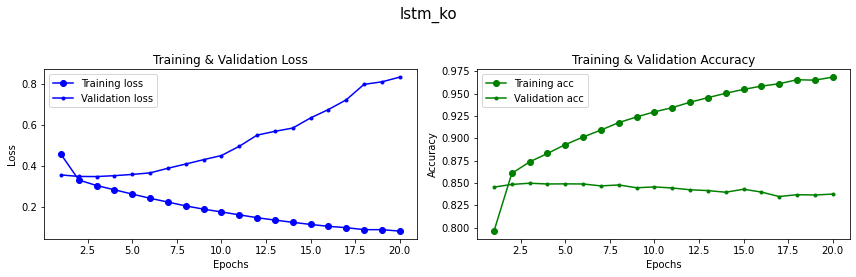

In [81]:
import matplotlib.pyplot as plt

lstm_ko_history_dict = lstm_ko_history.history

acc     = lstm_base_history_dict['accuracy']
val_acc = lstm_base_history_dict['val_accuracy']
loss    = lstm_base_history_dict['loss']
val_loss= lstm_base_history_dict['val_loss']
epochs  = range(1, len(acc) + 1)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# left subplot: Loss
ax1.plot(epochs, loss,    'bo-', label='Training loss')
ax1.plot(epochs, val_loss,'b.-', label='Validation loss')
ax1.set_title('Training & Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

# right subplot: Accuracy
ax2.plot(epochs, acc,     'go-', label='Training acc')
ax2.plot(epochs, val_acc, 'g.-', label='Validation acc')
ax2.set_title('Training & Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

fig.suptitle('lstm_ko', fontsize=15)

fig.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()